In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.scipy.linalg import solve
import matplotlib.pyplot as plt

In [2]:
def lagrangian(q, v):
    q3 = q.reshape(-1, 2)
    v3 = v.reshape(-1, 2)
    mass = jnp.array([1.0, 2.0, 3.0])
    i, j = jnp.tril_indices_from(q3, -1)
    distance = jnp.sqrt(jnp.sum((q3[i] - q3[j]) ** 2, axis=-1))
    return 0.5 * jnp.sum(mass[:, None] * v3 * v3) + jnp.sum(
        mass[i] * mass[j] / distance
    )


def hamiltonian_from_lagrangian(state):
    q, p = state
    # invert the fiber derivative
    v = solve(jax.jacobian(jax.jacobian(lambda v: lagrangian(q, v)))(jnp.ones(6)), p)
    return p @ v - lagrangian(q, v)


mass = jnp.array([1.0, 2.0, 3.0])


def kinetic_energy(state):
    _, p = state
    p3 = p.reshape(-1, 2)
    return 0.5 * jnp.sum(p3 * p3 / mass[:, None])


def potential_energy(state):
    q, _ = state
    q3 = q.reshape(-1, 2)
    i, j = jnp.tril_indices_from(q3, -1)
    invdistance = jnp.pow(jnp.sum((q3[i] - q3[j]) ** 2, axis=-1), -0.5)
    return -jnp.sum(mass[i] * mass[j] * invdistance)


def hamiltonian(state):
    return kinetic_energy(state) + potential_energy(state)

In [3]:
q0 = jnp.array([0.0, 1.0, 1.0, 0.0, -1.0, 0.0])
p0 = jnp.zeros(6)
state0 = jnp.array((q0, p0))

# much more fun
# state0 = jnp.array(
#     [
#         [
#             0.6733224710678404,
#             0.0006444390845759389,
#             -0.10733177312062013,
#             -0.06875982027365993,
#             -0.48621964160889125,
#             0.3789584004876191,
#         ],
#         [
#             3.6177035896412204,
#             -0.5416124691063872,
#             -2.475260691714918,
#             0.970244850494132,
#             -1.1424428979263148,
#             -0.428632381387655,
#         ],
#     ]
# )

dt = 2e-4
Nsteps = 50000
times = jnp.linspace(0, Nsteps * dt, Nsteps)

In [4]:
h0, dstate_dh = jax.vjp(hamiltonian, state0)
(co_state,) = dstate_dh(1.0)


def omega(v_state):
    """Symplectic form (maps tangent space to cotangent space)"""
    return jnp.array((-v_state[1], v_state[0]))


def Omega(co_state):
    """Symplectic form inverse (maps cotangent space to tangent space)"""
    return jnp.array((co_state[1], -co_state[0]))


# inverse symplectic form map gives us the Hamiltonian vector field
v_state = Omega(co_state)
h0prime, dh_dstate = jax.jvp(hamiltonian, (state0,), (v_state,))

assert jnp.allclose(h0, h0prime)
# this confirms that the Hamiltonian and symplectic form are in a consistent basis
assert jnp.allclose(dh_dstate, jnp.zeros(1))

In [5]:
def Xh(h, state):
    _, dstate_dh = jax.vjp(h, state)
    (co_state,) = dstate_dh(1.0)
    return Omega(co_state)


Xh(hamiltonian, state0)

Array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.35355339, -1.76776695, -2.20710678,  0.70710678,  2.56066017,
         1.06066017]], dtype=float64)

In [6]:
Omega(jax.jacobian(hamiltonian)(state0))

Array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.35355339, -1.76776695, -2.20710678,  0.70710678,  2.56066017,
         1.06066017]], dtype=float64)

In [7]:
from typing import Callable
from dataclasses import dataclass
from functools import partial
import warnings


@dataclass(frozen=True)
class IntegratorConfig:
    c: tuple[float]
    d: tuple[float]

    def __post_init__(self):
        assert len(self.c) == len(self.d)
        assert jnp.allclose(sum(self.c), 1)
        assert jnp.allclose(sum(self.d), 1)
        cond2a = sum(c * sum(self.d[i:]) for i, c in enumerate(self.c))
        cond2b = sum(c * sum(self.d[:i]) for i, c in enumerate(self.c))
        if not jnp.allclose(cond2a, 0.5) or not jnp.allclose(cond2b, 0.5):
            warnings.warn(
                f"Failed to satisfy the symplectic condition at second order for {self}"
            )
        seq = []
        for ci, di in zip(reversed(self.c), reversed(self.d)):
            if di != 0.0:
                seq.append(di)
            if ci != 0.0:
                seq.append(ci)
        if list(reversed(seq)) != seq:
            warnings.warn(f"Failed to satisfy symmetric condition for {self}")

    def steps(self):
        seq = [(0.0, 0.0)]
        for ci, di in zip(reversed(self.c), reversed(self.d)):
            if di != 0.0:
                seq.append((seq[-1][0], seq[-1][1] + di))
            if ci != 0.0:
                seq.append((seq[-1][0] + ci, seq[-1][1]))
        return jnp.array(seq)


@partial(jax.jit, static_argnums=(0, 3))
def symplectic_integrator(
    hamiltonian: Callable, state0, times, config: IntegratorConfig
):
    """Symplectic integrator for separable Hamiltonian systems
    
    We assume Hamiltonian is separable, i.e. H(q, p) = T(p) + V(q)
    and integrate it using a split-step symplectic integrator.
    
    TODO: time-dependent Hamiltonians
    TODO: adaptive time-stepping https://arxiv.org/pdf/1108.0322
    """
    H0 = hamiltonian(state0)
    q0, p0 = state0
    dHdq = jax.jacobian(lambda q, p: hamiltonian((q, p)), argnums=0)
    dHdp = jax.jacobian(lambda q, p: hamiltonian((q, p)), argnums=1)

    def body_fn(state, tnext):
        q, p, t = state
        dt = tnext - t
        # https://en.wikipedia.org/wiki/Symplectic_integrator or
        # Eqn. 7 https://fse.studenttheses.ub.rug.nl/20185/1/bMATH_2019_PimJC.pdf
        for ci, di in zip(reversed(config.c), reversed(config.d)):
            # since we unroll this in jit, let's skip zeros
            if di != 0.0:
                p = p - di * dt * dHdq(q, p)
            if ci != 0.0:
                q = q + ci * dt * dHdp(q, p)
        return (q, p, tnext), (q, p, hamiltonian((q, p)))

    _, (q, p, H) = jax.lax.scan(body_fn, (q0, p0, times[0]), times[1:])
    return (
        jnp.concatenate((q0[None], q)),
        jnp.concatenate((p0[None], p)),
        jnp.concatenate((H0[None], H)),
    )


leapfrog_config = IntegratorConfig((1, 0), (0, 1))
q, p, H = symplectic_integrator(hamiltonian, state0, times, leapfrog_config)
leapfrog_track = jnp.array((q, p))
leapfrog_energy = H

verlet2_config = IntegratorConfig((0, 1), (0.5, 0.5))
q, p, H = symplectic_integrator(hamiltonian, state0, times, verlet2_config)
verlet2_track = jnp.array((q, p))
verlet2_energy = H

# https://cds.cern.ch/record/143981/files/cer-000055082.pdf
ruth3_config = IntegratorConfig((1, -2 / 3, 2 / 3), (-1 / 24, 3 / 4, 7 / 24))
q, p, H = symplectic_integrator(hamiltonian, state0, times, ruth3_config)
ruth3_track = jnp.array((q, p))
ruth3_energy = H


def make_yoshida4():
    x0 = -(2 ** (1 / 3)) / (2 - 2 ** (1 / 3))
    x1 = 1 / (2 - 2 ** (1 / 3))
    c1c4 = x1 / 2
    c2c3 = (x1 + x0) / 2
    d1d3 = x1
    d2 = x0
    return IntegratorConfig(
        c=(c1c4, c2c3, c2c3, c1c4),
        d=(d1d3, d2, d1d3, 0.0),
    )


yoshida4_config = make_yoshida4()
q, p, H = symplectic_integrator(hamiltonian, state0, times, yoshida4_config)
yoshida4_track = jnp.array((q, p))
yoshida4_energy = H

/var/folders/1k/cjwws80d2w3dlxwd9fqg5dfr0000j6/T/ipykernel_21676/1671868356.py:19: UserWarning: Failed to satisfy the symplectic condition at second order for IntegratorConfig(c=(1, 0), d=(0, 1))
  warnings.warn(
/var/folders/1k/cjwws80d2w3dlxwd9fqg5dfr0000j6/T/ipykernel_21676/1671868356.py:29: UserWarning: Failed to satisfy symmetric condition for IntegratorConfig(c=(1, -0.6666666666666666, 0.6666666666666666), d=(-0.041666666666666664, 0.75, 0.2916666666666667))
  warnings.warn(f"Failed to satisfy symmetric condition for {self}")


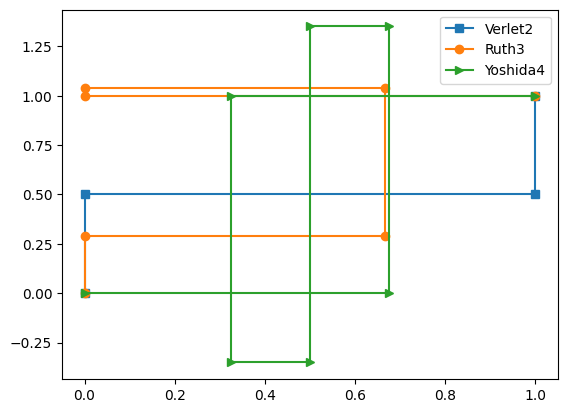

In [8]:
fig, ax = plt.subplots()

ax.plot(*verlet2_config.steps().T, marker="s", label="Verlet2")
ax.plot(*ruth3_config.steps().T, marker="o", label="Ruth3")
ax.plot(*yoshida4_config.steps().T, marker=">", label="Yoshida4")

ax.legend()

In [9]:
@partial(jax.jit, static_argnums=(0,))
def flow_integrator(hamiltonian: Callable, state0, times):
    H0 = hamiltonian(state0)

    def hflow(state):
        return Omega(jax.jacobian(hamiltonian)(state))

    def body_fn(carry, tnext):
        state, t = carry
        dt = tnext - t
        flow = hflow(state)
        flow2 = jax.jvp(hflow, (state,), (flow,))[1]
        state = state + dt * flow + 0.5 * dt**2 * flow2
        return (state, tnext), (state, hamiltonian(state), jnp.sum(flow2 * flow))

    _, (track, H, flow) = jax.lax.scan(body_fn, (state0, times[0]), times[1:])
    track = jnp.concatenate((state0[None], track))
    return (
        track[:, 0],
        track[:, 1],
        jnp.concatenate((H0[None], H)),
        jnp.concatenate((jnp.zeros_like(flow[0])[None], flow)),
    )


q, p, H, flow = flow_integrator(hamiltonian, state0, times)
flow2_track = jnp.array((q, p))
flow2_energy = H

In [10]:
from jax.experimental.ode import odeint


@partial(jax.jit, static_argnums=(0,))
def rk_integrator(hamiltonian: Callable, state0, times):
    def deriv(state, _):
        return Omega(jax.jacobian(hamiltonian)(state))

    track = odeint(deriv, state0, times)
    H = jax.vmap(hamiltonian, (0,), 0)(track)
    return (track[:, 0], track[:, 1], H)


q, p, H = rk_integrator(hamiltonian, state0, times)
rk_track = jnp.array((q, p))
rk_energy = H

In [11]:
# %timeit symplectic_integrator(hamiltonian, state0, times, yoshida4_config)
# %timeit rk_integrator(hamiltonian, state0, times)

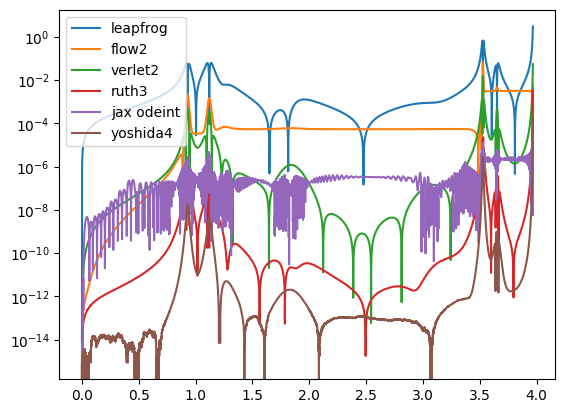

In [12]:
fig, ax = plt.subplots()

H0 = hamiltonian(state0)
# ax.axhline(H0, color="k", linestyle=":", label="initial energy")
cut = slice(0, 19840)
ax.plot(times[cut], abs(leapfrog_energy[cut] - H0), label="leapfrog")
ax.plot(times[cut], abs(flow2_energy[cut] - H0), label="flow2")
ax.plot(times[cut], abs(verlet2_energy[cut] - H0), label="verlet2")
ax.plot(times[cut], abs(ruth3_energy[cut] - H0), label="ruth3")
ax.plot(times[cut], abs(rk_energy[cut] - H0), label="jax odeint")
ax.plot(times[cut], abs(yoshida4_energy[cut] - H0), label="yoshida4")
# a potential measure of the error in the flow?
# ax.plot(times[cut], jnp.log(jnp.abs(flow[cut] * dt)), label="flow")

ax.set_yscale("log")
ax.legend()

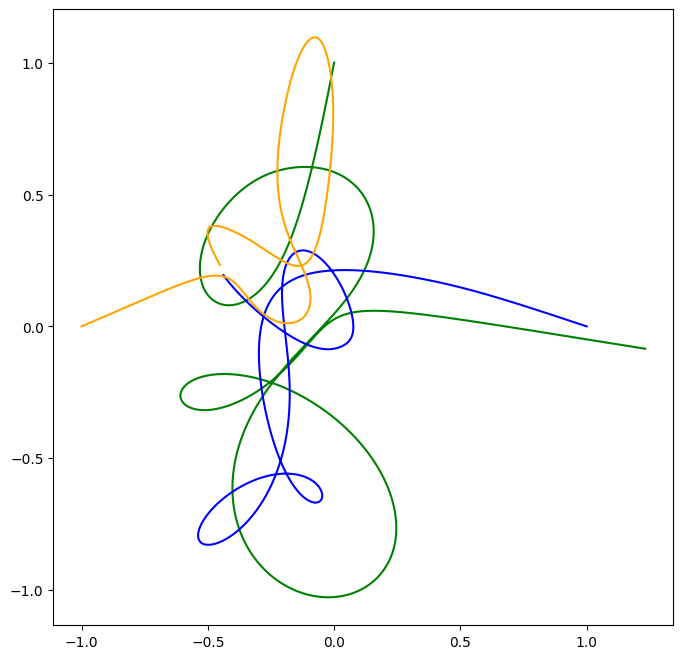

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

paths = rk_track[0].reshape(-1, 3, 2)[cut, :, :]
ax.plot(paths[:, 0, 0], paths[:, 0, 1], color="green")
ax.plot(paths[:, 1, 0], paths[:, 1, 1], color="blue")
ax.plot(paths[:, 2, 0], paths[:, 2, 1], color="orange")

# paths = yoshida4_track[1].reshape(-1, 3, 2)[cut, :, :]
# ax.plot(paths[:, 0, 0], paths[:, 0, 1], color="green", linestyle="--")
# ax.plot(paths[:, 1, 0], paths[:, 1, 1], color="blue", linestyle="--")
# ax.plot(paths[:, 2, 0], paths[:, 2, 1], color="orange", linestyle="--")

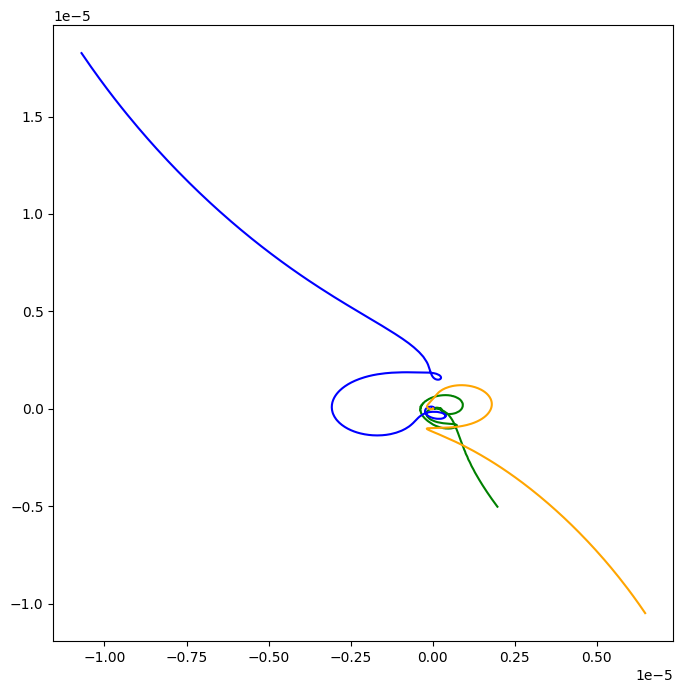

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

dpath = (rk_track[0] - yoshida4_track[0]).reshape(-1, 3, 2)[cut, :, :]
ax.plot(dpath[:, 0, 0], dpath[:, 0, 1], color="green")
ax.plot(dpath[:, 1, 0], dpath[:, 1, 1], color="blue")
ax.plot(dpath[:, 2, 0], dpath[:, 2, 1], color="orange")